In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn import preprocessing
from datetime import datetime, timedelta

In [2]:
'''import'''

data = pd.read_csv("../../cephfs/cleanedData/2022-02_sample.csv", parse_dates=['GlucoseDisplayTime'])

In [3]:
'''use just one patient'''
patIDs = data.PatientId.unique()
i = 0
subset = data[data['PatientId']==patIDs[i]].copy()
subset

,PatientId,GlucoseDisplayTime,GlucoseDisplayTimeRaw,Value,dayCSV
0,2189,2022-02-01 01:35:54.162,2022-02-01T01:35:54.162-06:00,0,1
1,2189,2022-01-31 18:10:49.212,2022-01-31T18:10:49.212-06:00,0,1
2,2189,2022-01-31 22:20:51.624,2022-01-31T22:20:51.624-06:00,0,1
3,2189,2022-02-01 08:00:59.366,2022-02-01T08:00:59.366-06:00,0,1
4,2189,2022-02-01 15:20:57.416,2022-02-01T15:20:57.416-06:00,0,1
...,...,...,...,...,...
778435,2189,2022-02-28 12:00:36.000,2022-02-28T12:00:36.000-06:00,166,28
778436,2189,2022-02-28 07:05:36.000,2022-02-28T07:05:36.000-06:00,171,28
778437,2189,2022-02-28 09:40:36.000,2022-02-28T09:40:36.000-06:00,187,28
778438,2189,2022-02-27 22:10:36.000,2022-02-27T22:10:36.000-06:00,173,28


# the actual fill-in-missing-values process

In [4]:
'''replace 0s with NaN to save a two steps down the line'''
subset['Value'] = subset['Value'].replace(0, np.nan)

'''drop duplicate datetimes for each patient'''
subset = subset.drop_duplicates(subset='GlucoseDisplayTime', keep="first")

ogNon0Values = subset['Value'].replace(0, np.nan).count()
print("starting with", ogNon0Values, "nonzero glucose measurements ('Value')")
# print(subset.info())

'''set datetime as index in order for resampling method below to work'''
subset = subset.set_index('GlucoseDisplayTime')
subset.info()

starting with 7700 nonzero glucose measurements ('Value')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8059 entries, 2022-02-01 01:35:54.162000 to 2022-02-28 07:30:36
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PatientId              8059 non-null   int64  
 1   GlucoseDisplayTimeRaw  8059 non-null   object 
 2   Value                  7700 non-null   float64
 3   dayCSV                 8059 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 314.8+ KB


In [5]:
'''fill in missing timestamps'''
subset = subset.resample('5min').first()

'''fix columns that *need* to be filled in'''
subset['PatientId'] = subset['PatientId'].replace(np.nan, patIDs[i])
# subset['GlucoseDisplayTimeRaw'] = subset.index.strftime('%Y-%m-%d') #check documentation for how to format
# subset['dayCSV'] = subset['dayCSV'].replace(np.nan, -1)

print(subset.info())
subset

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8068 entries, 2022-01-31 17:20:00 to 2022-02-28 17:35:00
Freq: 5T
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PatientId              8068 non-null   float64
 1   GlucoseDisplayTimeRaw  8051 non-null   object 
 2   Value                  7697 non-null   float64
 3   dayCSV                 8051 non-null   float64
dtypes: float64(3), object(1)
memory usage: 315.2+ KB
None


,PatientId,GlucoseDisplayTimeRaw,Value,dayCSV
GlucoseDisplayTime,,,,
2022-01-31 17:20:00,2189.0,2022-01-31T17:20:38.000-06:00,207.0,1.0
2022-01-31 17:25:00,2189.0,2022-01-31T17:25:38.000-06:00,207.0,1.0
2022-01-31 17:30:00,2189.0,2022-01-31T17:30:38.000-06:00,212.0,1.0
2022-01-31 17:35:00,2189.0,2022-01-31T17:35:49.465-06:00,NaN,1.0
2022-01-31 17:40:00,2189.0,2022-01-31T17:40:48.583-06:00,NaN,1.0
...,...,...,...,...
2022-02-28 17:15:00,2189.0,2022-02-28T17:15:37.000-06:00,154.0,28.0
2022-02-28 17:20:00,2189.0,2022-02-28T17:20:36.000-06:00,157.0,28.0
2022-02-28 17:25:00,2189.0,2022-02-28T17:25:36.000-06:00,158.0,28.0


In [6]:
'''resampling has the capacity to lose us some glucose measurements, so check for that'''
newNon0Values = subset['Value'].replace(0, np.nan).count()
if ogNon0Values-newNon0Values > 0:
    print(ogNon0Values-newNon0Values, "glucose measurements lost in resampling")
elif ogNon0Values-newNon0Values < 0:
    print("Somehow resampling *added* glucose measurements and that means something went wrong")

3 glucose measurements lost in resampling


In [7]:
'''label which values need filling'''
subset['missing'] = False
subset.loc[subset['Value'].isna(), 'missing'] = True

# subset.info()
subset.groupby('missing').count()

,PatientId,GlucoseDisplayTimeRaw,Value,dayCSV
missing,,,,
False,7697,7697,7697,7697
True,371,354,0,354


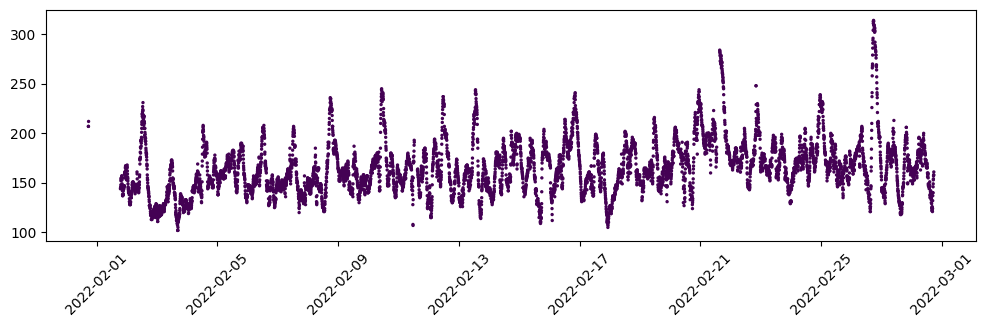

In [8]:
'''pause to visualize'''
plt.figure(figsize=(12,3))
plt.scatter(subset.index, subset.Value, c=subset.missing, s=2)
plt.xticks(rotation=45)
plt.show()

In [9]:
'''interpolate'''
subset['Value'] = subset['Value'].interpolate(method='pchip')
missing_vals = subset[subset['missing'] == 1].index
for i in missing_vals:
    lower_t = i - timedelta(hours = 5)
    upper_t = i - timedelta(hours = 3)
    std_prev = np.sqrt(np.std(subset.loc[lower_t:upper_t, 'Value']))
    jiggle = std_prev*np.random.randn()
    subset.loc[i, 'Value'] = subset.loc[i, 'Value'] + jiggle

subset

,PatientId,GlucoseDisplayTimeRaw,Value,dayCSV,missing
GlucoseDisplayTime,,,,,
2022-01-31 17:20:00,2189.0,2022-01-31T17:20:38.000-06:00,207.0,1.0,False
2022-01-31 17:25:00,2189.0,2022-01-31T17:25:38.000-06:00,207.0,1.0,False
2022-01-31 17:30:00,2189.0,2022-01-31T17:30:38.000-06:00,212.0,1.0,False
2022-01-31 17:35:00,2189.0,2022-01-31T17:35:49.465-06:00,NaN,1.0,True
2022-01-31 17:40:00,2189.0,2022-01-31T17:40:48.583-06:00,NaN,1.0,True
...,...,...,...,...,...
2022-02-28 17:15:00,2189.0,2022-02-28T17:15:37.000-06:00,154.0,28.0,False
2022-02-28 17:20:00,2189.0,2022-02-28T17:20:36.000-06:00,157.0,28.0,False
2022-02-28 17:25:00,2189.0,2022-02-28T17:25:36.000-06:00,158.0,28.0,False


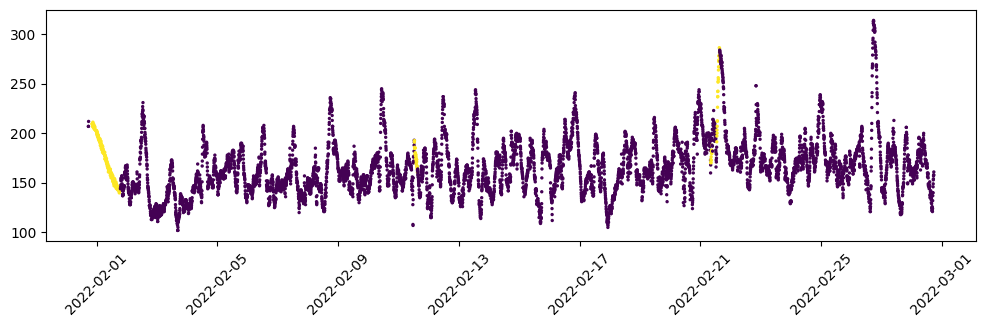

In [10]:
'''pause to visualize'''
plt.figure(figsize=(12,3))
plt.scatter(subset.index, subset.Value, c=subset.missing, s=2)
plt.xticks(rotation=45)
plt.show()